# 1. Introduction

<center> 
<div>
<img src="https://forcaaerea.com.br/wp-content/uploads/2022/04/KC390_JUL2018-1536x1024.jpg" width="600"/>
</div>
(Photo by: Embraer) </center> 

The Brazilian Aeronautical Registry (RAB) is an important source of data for analysis and studies related to aviation in Brazil. Understanding and extracting valuable insights from this data is critical to everything from aviation safety to airline operational efficiency.

In this work, we propose a comprehensive analysis of data from the Brazilian Aeronautical Registry, using data analysis and machine learning techniques. Our goal is to explore the characteristics of aeronautical records and apply machine learning models to identify trends, patterns and useful insights.

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error
import xgboost as xgb
from category_encoders import TargetEncoder
import optuna
import warnings

warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('aircrafts.csv')

df_old = df.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23801 entries, 0 to 23800
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   owner                        23787 non-null  object 
 1   owner_id                     22366 non-null  float64
 2   owner_type                   22063 non-null  object 
 3   owner_state                  22744 non-null  object 
 4   num_other_owners             23801 non-null  float64
 5   property_type                23726 non-null  object 
 6   operator                     22880 non-null  object 
 7   operator_id                  21895 non-null  float64
 8   operator_type                21601 non-null  object 
 9   operator_state               22405 non-null  object 
 10  num_other_operators          23801 non-null  float64
 11  use_rights                   7916 non-null   object 
 12  airworthiness                23801 non-null  object 
 13  registration_num

Before getting into the data analysis, let's describe what each feature means:

**owner**: Primary owner of the aircraft. <br>
**owner_id:** Owner identifier. <br>
**owner_type:** natural/legal owner (natural/legal) <br>
**owner_state:** Owner State. <br>
**num_other_owners:** Number of other Owners. <br>
**property_type:** Public/Private. <br>
**operator:** Primary operator of the aircraft. <br>
**operator_id:** Operator Identifier. <br>
**operator_type:** Physical/legal operator (natural/legal) <br>
**operator_state:** Operator State. <br>
**num_other_operators:** Number of other Operators. <br>
**use_rights:** Legal instrument for the use of the aircraft. <br>
**Airworthiness:** Airworthiness. <br>
**registration_number:** Registration number. Must be unique for each aircraft. <br>
**certification_type:** Type of certification the pilot needs to have to fly an airplane. <br>
**anac_type_classification:** Classification of aircraft characteristics prepared by ANAC. <br>
**icao_type_classification:** Classification of aircraft characteristics created by ICAO. <br>
**using_classification:** Aircraft usage classification created by ANAC. <br>
**Annual_inspec_status:** Mandatory annual protection status. <br>
**exp_date_annual_inspection:** Due date of the annual inspection. <br>
**special_inspec_status:** Mandatory special protection status. <br>
**exp_date_special_inspection:** Special inspection due date. <br>
**Model:** Model Airplane. <br>
**manufacturer:** Airplane manufacturer. <br>
**serial_number:** Aircraft serial number. Must be unique for each aircraft produced on a production line. <br>
**year_manufacture:** Year of Manufacture. <br>
**max_weight_takeoff:** Maximum takeoff weight (MTOW). <br>
**min_number_crew:** Minimum number of crew. <br>
**max_number_passengers:** Maximum number of passengers. <br>
**Seats:** Number of seats. <br>
**landing_type:** Type of landing. <br>
**engine_count:** Number of engines. <br>
**engine_type:** Engine type. <br>

The dataset may contain some inconsistencies due to the registry and the cleaning process itself. One of these inconsistencies is the existence of duplicate registration of aviation numbers, unique for each example, and zero weight aircraft. Let's remove them.

In [5]:
df = df.drop_duplicates('registration_number')
df = df.drop(df.loc[df['max_weight_takeoff'] == 0, :].index)


Our data contains a significant number of features with missing data. With a quick evaluation we can get the percentage of missing data for each feature

In [6]:
for c in df.columns:
    
    per = df.loc[:, c].isnull().sum() / len(df)
    
    print(f'Missing Data in feature {c:27s}: {per * 100:5.2f}%')

Missing Data in feature owner                      :  0.03%
Missing Data in feature owner_id                   :  6.62%
Missing Data in feature owner_type                 :  8.04%
Missing Data in feature owner_state                :  4.86%
Missing Data in feature num_other_owners           :  0.00%
Missing Data in feature property_type              :  0.08%
Missing Data in feature operator                   :  0.02%
Missing Data in feature operator_id                :  2.39%
Missing Data in feature operator_type              :  3.76%
Missing Data in feature operator_state             :  0.04%
Missing Data in feature num_other_operators        :  0.00%
Missing Data in feature use_rights                 : 70.15%
Missing Data in feature airworthiness              :  0.00%
Missing Data in feature registration_number        :  0.00%
Missing Data in feature certification_type         :  5.62%
Missing Data in feature anac_type_classification   :  0.27%
Missing Data in feature icao_type_classi

Based on the number of missing data and aiming to define a scope for our data analysis, we will remove some features in order to focus on the most important ones.

In [7]:
dropping = ['exp_date_annual_inspection', 'annual_inspec_status',
            'exp_date_special_inspection', 'special_inspec_status',
            'use_rights', 'airworthiness', 'anac_type_classification',
            'icao_type_classification', 'serial_number']

df = df.drop(dropping, axis = 1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21120 entries, 0 to 23800
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   owner                  21113 non-null  object 
 1   owner_id               19722 non-null  float64
 2   owner_type             19423 non-null  object 
 3   owner_state            20094 non-null  object 
 4   num_other_owners       21120 non-null  float64
 5   property_type          21104 non-null  object 
 6   operator               21115 non-null  object 
 7   operator_id            20616 non-null  float64
 8   operator_type          20326 non-null  object 
 9   operator_state         21111 non-null  object 
 10  num_other_operators    21120 non-null  float64
 11  registration_number    21119 non-null  float64
 12  certification_type     19933 non-null  object 
 13  usage_classification   21117 non-null  object 
 14  model                  21101 non-null  object 
 15  ma

# 2. Data Analysis

## 2.1. Owner and Operator

In [9]:
owner_name = len(df.loc[:, 'owner'].unique())
owner_id = len(df.loc[:, 'owner_id'].unique())

print(f'Unique owner names: {owner_name}')
print(f'Unique owner IDs:   {owner_id}')

Unique owner names: 14893
Unique owner IDs:   13123


In [10]:
operator_name = len(df.loc[:, 'operator'].unique())
operator_id = len(df.loc[:, 'operator_id'].unique())

print(f'Unique operator names: {operator_name}')
print(f'Unique operator IDs:   {operator_id}')

Unique operator names: 14868
Unique operator IDs:   13317


The number of owners/operators exceeds the number of IDs, this means that there may be owners/operators with more than one registered name. This is important for owner/operator queries, as it informs us that we should not use their names to make inquiries, but their respective IDs.

In [11]:
df['property_type'].value_counts(normalize = True)

Privada    0.979293
Pública    0.020707
Name: property_type, dtype: float64

There are very few examples of public aircraft in Brazil.

In [12]:
series = df['owner_id'].value_counts().to_frame().reset_index()
series = series.rename(columns = {'index':'owner_id', 'owner_id': 'num_owned'})
mask = df['owner_id'].isin(series['owner_id'])

df_op = df.loc[mask, ['owner', 'owner_id', 'property_type', 'owner_type']].drop_duplicates('owner_id')

df_op = pd.merge(series, df_op, on = 'owner_id').drop_duplicates('owner_id')

df_op = df_op.drop('owner_id', axis = 1)

#df_op['property_type'] = df_op['property_type'].replace({'Privada': 1, 'Pública': 0})

df_op = df_op[['owner', 'num_owned', 'property_type', 'owner_type']]

df_op.head(20).style.background_gradient(axis=0)

,owner,num_owned,property_type,owner_type
0,BRADESCO LEASING S.A ARREND.MERCANTIL,206,Privada,Legal
1,GOVERNO FEDERAL ANAC,182,Privada,Legal
2,BANCO BRADESCO S.A,104,Privada,Not identified
3,AGENCIA NACIONAL DE AVIACAO CIVIL ANAC,88,Privada,Legal
4,GOVERNO FEDERAL - ANAC,63,Pública,Legal
5,EJ - ESCOLA DE AVIACAO CIVIL LTDA,56,Privada,Legal
6,AIR TRACTOR,50,Privada,Legal
7,SANTANDER LEASING S.A. ARREND.MERCANTIL,46,Privada,Legal
8,HELISUL TAXI AEREO LTDA C240796,43,Privada,Legal
9,AEROCLUBE DE SAO PAULO,42,Privada,Legal


In [13]:
num_nat = df_op[df_op['owner_type'] == 'Natural'].iloc[0, 1]

print(f'Number of highest air fleet owned by a natural owner: {num_nat}')

Number of highest air fleet owned by a natural owner: 13


It is observed that among the twenty owners with the largest aircraft strengths, the overwhelming majority is private domain and legal entities. It is noted that there is no individual with an aeronautical fleet of more than 13 aircrafts.

In [14]:
df_ = df.copy()

df = df.loc[:, ['owner_id', 'owner_type', 'owner_state', 'num_other_owners',
           'operator_id', 'operator_type', 'operator_state', 'num_other_operators']].drop_duplicates()

In [15]:
mask1 = (df['owner_type'].isnull())
mask2 = (df['operator_type'].isnull())

df.loc[mask1, 'owner_type'] = 'Not identified'
df.loc[mask2, 'operator_type'] = 'Not identified'

ow_type = df['owner_type'].value_counts(normalize=True) * 100
op_type = df['operator_type'].value_counts(normalize=True) * 100

df_type = pd.concat([ow_type, op_type], axis = 1)
df_type.style.background_gradient(axis=0)

,owner_type,operator_type
Natural,54.940941,52.436584
Legal,35.248177,40.282708
Not identified,9.810882,7.280707


The number of natural owners exceeds the number of legal owners, both for operators and for owners.

In [16]:
# owner state

mask1 = (df['owner_state'].isnull())
mask2 = (df['operator_state'].isnull())

df.loc[mask1, 'owner_state'] = 'Not identified'
df.loc[mask2, 'operator_state'] = 'Not identified'

ow_state = df['owner_state'].value_counts(normalize=True) * 100
op_state = df['operator_state'].value_counts(normalize=True) * 100

df_state = pd.concat([ow_state, op_state], axis = 1)
lst = df_state.index.to_list()
lst.remove('Not identified')
lst.append('Not identified')

df_state = df_state.loc[lst, :]

df_state.style.background_gradient(axis=0)

,owner_state,operator_state
SP,28.316014,26.482928
MG,8.294068,9.036339
PR,7.480798,8.042342
MT,7.003163,8.029433
GO,6.448073,7.054799
RS,5.441167,5.763893
RJ,5.337895,4.363261
PA,4.208352,4.614987
MS,4.053443,4.305170
SC,3.407991,3.614536


There is a higher proportion of owners and operators in the states of São Paulo (SP) and Minas Gerais (MG), both of which are the most populous states in Brazil. However, [evaluating the population in other Brazilian states](https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_popula%C3%A7%C3%A3o), it is seen that the population is not always an indication of the proportion of owners and operators. Mato Grosso (MT) is the 17th most populous state, but it is the 4th with the most owners and operators.

In [17]:
#df_region

SE = ['SP', 'RJ', 'MG', 'ES'] 
CW = ['MT', 'MS', 'GO', 'DF']
S = ['RS', 'PR', 'SC']
NE = ['MA', 'CE', 'BA', 'PI', 'RN', 'PB', 'PE', 'AL', 'SE']
N = ['AC', 'RO', 'RR', 'AM', 'PA', 'AP', 'TO']

regions = ['SE', 'CW', 'S', 'NE', 'N']

dic_regions = {
    'SE': SE,
    'CW': CW,
    'S': S,
    'NE': NE,
    'N': N
}

df['owner_region'] = 'Not identified'
df['operator_region'] = 'Not identified'

for key, value in dic_regions.items():
    mask1 = df['owner_state'].isin(value)
    mask2 = df['operator_state'].isin(value)
    
    df.loc[mask1, 'owner_region'] = key
    df.loc[mask2, 'operator_region'] = key

ow_region = df['owner_region'].value_counts(normalize=True) * 100
op_region = df['operator_region'].value_counts(normalize=True) * 100

df_region = pd.concat([ow_region, op_region], axis = 1)
df_region.style.background_gradient(axis=0)

,owner_region,operator_region
SE,43.058155,41.012070
CW,20.441490,21.900213
S,16.329955,17.420771
N,9.307429,10.178790
NE,8.474795,9.436520
Not identified,2.388175,0.051636


Looking at the regions, it can be seen that the Southeast (SE) region concentrates most of the owners and operators, justified by being the most populous region. However, it is followed by the Centerwest (CW), the region with the **smallest** population. Northeast (NE), the second most populous region, is in last place in relation to the number of owners and operators. This can be explained by the concentration of agricultural activities in the Centerwest region, which demand the intensive use of aircrafts.

In [18]:
op_num = df['num_other_operators'].value_counts(normalize=True) * 100
ow_num = df['num_other_owners'].value_counts(normalize=True) * 100

df_num = pd.concat([ow_num, op_num], axis = 1)

ind = np.argsort(df_num.index)

df_num = df_num.iloc[ind]

df_num.style.background_gradient(axis=0)

,num_other_owners,num_other_operators
0.000000,94.629833,96.359646
1.000000,3.672626,2.530175
2.000000,1.110179,0.742271
3.000000,0.387272,0.232363
4.000000,0.122636,0.083909
5.000000,0.045182,0.025818
6.000000,nan,0.012909
7.000000,0.019364,0.006455
8.000000,0.012909,nan
13.000000,nan,0.006455


The vast majority of aircrafts does not have a different operator or owner.

In [19]:
mask1 = (df['owner_type'] == 'Natural')
mask2 = (df['owner_type'] == 'Legal')

self_nat = (df.loc[mask1, 'owner_id'] == df.loc[mask1, 'operator_id']).sum() / len(df.loc[mask1]) * 100
self_leg = (df.loc[mask2, 'owner_id'] == df.loc[mask2, 'operator_id']).sum() / len(df.loc[mask2]) * 100

mask3 = (df.loc[mask1, 'owner_id'] != df.loc[mask1, 'operator_id'])
mask4 = (df.loc[mask2, 'owner_id'] != df.loc[mask2, 'operator_id'])

mask5 = (df['operator_type'] == 'Natural')
mask6 = (df['operator_type'] == 'Legal')
mask7 = (df['operator_type'] == 'Not identified')

nat_op_nat = len(df.loc[(mask3 & mask5)]) / len(df.loc[mask1]) * 100
leg_op_nat = len(df.loc[(mask4 & mask5)]) / len(df.loc[mask2]) * 100
nat_op_leg = len(df.loc[(mask3 & mask6)]) / len(df.loc[mask1]) * 100
leg_op_leg = len(df.loc[(mask4 & mask6)]) / len(df.loc[mask2]) * 100
nat_op_not = len(df.loc[(mask3 & mask7)]) / len(df.loc[mask1]) * 100
leg_op_not = len(df.loc[(mask4 & mask7)]) / len(df.loc[mask2]) * 100

df_ow_op = pd.DataFrame(data = [
    [self_nat, self_leg],
    [nat_op_nat, leg_op_nat],
    [nat_op_leg, leg_op_leg],
    [nat_op_not, leg_op_not],
], index = [
    'operate by owner',
    'operate by natural',
    'operate by legal',
    'Not identified'
], columns = [
    'natural owner',
    'legal owner'
]

)

df_ow_op = df_ow_op.sort_values('natural owner', ascending = False)

df_ow_op.style.background_gradient(axis=0)

,natural owner,legal owner
operate by owner,84.515977,68.412379
operate by legal,9.151786,23.585424
operate by natural,5.133929,6.555576
Not identified,1.198308,1.446621


Based on the analysis, most aircraft are operated by the owners themselves, whether physical or legal. See that legal owners operate less than physical ones, and prefer legal operators when they are not the ones who operate.

In [20]:
mask1 = (df['owner_type'] == 'Natural')
mask2 = (df['owner_type'] == 'Legal')

self_state_nat = (df.loc[mask1, 'owner_state'] == df.loc[mask1, 'operator_state']).sum() / len(df.loc[mask1]) * 100
self_state_leg = (df.loc[mask2, 'owner_state'] == df.loc[mask2, 'operator_state']).sum() / len(df.loc[mask2]) * 100

mask3 = (df.loc[mask1, 'owner_state'] != df.loc[mask1, 'operator_state'])
mask4 = (df.loc[mask2, 'owner_state'] != df.loc[mask2, 'operator_state'])

mask7 = (df['operator_state'] == 'Not identified')

nat_op_diff = len(df.loc[(mask3 & ~mask5)]) / len(df.loc[mask1]) * 100
leg_op_diff = len(df.loc[(mask4 & ~mask5)]) / len(df.loc[mask2]) * 100
nat_op_not = len(df.loc[(mask3 & mask5)]) / len(df.loc[mask1]) * 100
leg_op_not = len(df.loc[(mask4 & mask5)]) / len(df.loc[mask2]) * 100

df_ow_op = pd.DataFrame(data = [
    [self_state_nat, self_state_leg],
    [nat_op_diff, leg_op_diff],
    [nat_op_not, leg_op_not],
], index = [
    'same state',
    'different state',
    'Not identified'
], columns = [
    'natural owner',
    'legal owner'
]

)

df_ow_op = df_ow_op.sort_values('natural owner', ascending = False)

df_ow_op.style.background_gradient(axis=0)

,natural owner,legal owner
same state,93.573778,81.541842
different state,3.277726,14.484527
Not identified,3.148496,3.973631


Operators are usually from the same state as the owners, with more operators from the same state when the owners are physical.

In [21]:
mask1 = (df['owner_type'] == 'Natural')
mask2 = (df['owner_type'] == 'Legal')

self_region_nat = (df.loc[mask1, 'owner_region'] == df.loc[mask1, 'operator_region']).sum() / len(df.loc[mask1]) * 100
self_region_leg = (df.loc[mask2, 'owner_region'] == df.loc[mask2, 'operator_region']).sum() / len(df.loc[mask2]) * 100

mask3 = (df.loc[mask1, 'owner_region'] != df.loc[mask1, 'operator_region'])
mask4 = (df.loc[mask2, 'owner_region'] != df.loc[mask2, 'operator_region'])

mask7 = (df['operator_state'] == 'Not identified')

nat_op_diff = len(df.loc[(mask3 & ~mask5)]) / len(df.loc[mask1]) * 100
leg_op_diff = len(df.loc[(mask4 & ~mask5)]) / len(df.loc[mask2]) * 100
nat_op_not = len(df.loc[(mask3 & mask5)]) / len(df.loc[mask1]) * 100
leg_op_not = len(df.loc[(mask4 & mask5)]) / len(df.loc[mask2]) * 100

df_ow_op = pd.DataFrame(data = [
    [self_region_nat, self_region_leg],
    [nat_op_diff, leg_op_diff],
    [nat_op_not, leg_op_not],
], index = [
    'same region',
    'different region',
    'Not identified'
], columns = [
    'natural owner',
    'legal owner'
]

)

df_ow_op.style.background_gradient(axis=0)

,natural owner,legal owner
same region,95.030545,86.705732
different region,2.384868,10.199597
Not identified,2.584586,3.094671


We see the same pattern for regions that we saw for states.

In [22]:
mask = (df['owner_state'] == df['operator_state'])
mask_not = (df['operator_state'] == 'Not identified') | (df['owner_state'] == 'Not identified')


df['same_state'] = 0

df.loc[mask, 'same_state']  = 1

df_same_state = df.loc[~mask_not, ['owner_state', 'same_state']].groupby('owner_state').sum()['same_state']

df_same_state = df_same_state / df.loc[~mask_not, 'owner_state'].value_counts() * 100 

df_same_state = df_same_state.sort_values(ascending=False)

df_same_state.to_frame(name = 'owner_same_state').style.background_gradient(axis=0)

,owner_same_state
AL,100.000000
PE,98.360656
RN,95.312500
MG,94.310210
MA,93.953488
GO,93.793794
CE,93.750000
MT,93.640553
PB,93.421053
RS,93.238434


Rio de Janeiro (RJ) and Distrito Federal (DF) are states with the least of owner with operators in the same state.

In [23]:
mask = (df['owner_region'] == df['operator_region'])
mask_not = (df['operator_region'] == 'Not identified') | (df['owner_region'] == 'Not identified')

df['same_region'] = 0

df.loc[mask, 'same_region']  = 1

df_same_state = df.loc[~mask_not, ['owner_region', 'same_region']].groupby('owner_region').sum()['same_region']

df_same_state = df_same_state / df.loc[~mask_not, 'owner_region'].value_counts() * 100 

df_same_state = df_same_state.sort_values(ascending=False)

df_same_state.to_frame(name = 'owner_same_region').style.background_gradient(axis=0)

,owner_same_region
S,94.071146
N,93.962526
NE,93.830922
CW,93.274392
SE,89.857464


In [24]:
big_op  = df.groupby('operator_id').count()['owner_id'].sort_values(ascending = False).head(20)


In [25]:
series = df_.loc[:, ['operator_id', 'operator', 'operator_state']].drop_duplicates()

df_op = pd.merge(series, big_op, on = 'operator_id').drop_duplicates('operator_id')

df_op = df_op.drop('operator_id', axis = 1)

df_op = df_op.rename(columns = {
    'owner_id': 'num_owners'
}).sort_values('num_owners', ascending = False)

df_op.style.background_gradient(axis=0)

,operator,operator_state,num_owners
9,LIDER TAXI AEREO S.A - AIR BRASIL,MG,17
18,AEROCLUBE DE JUIZ DE FORA,MG,14
42,AEROCLUBE DO ESTADO DE MINAS GERAIS,MG,13
16,AEROCLUBE DE GOIAS,GO,12
22,ICON TAXI AEREO LTDA,SP,12
24,PIQUIATUBA TAXI AEREO LTDA,PA,11
33,COMBATE AVIAÇÃO AGRICOLA LTDA ¿ ME,GO,11
60,JOAO VIVIANI,SP,10
19,HELISUL TAXI AEREO LTDA,PR,10
39,TACA TAXI AEREO CANDIDO LTDA,PA,10



The operators with the highest number of piloted aircraft are flying clubs or air taxis, with a concentration in the state of Minas Gerais (MG).

In [26]:
df = df_.copy()

In [27]:
SE = ['SP', 'RJ', 'MG', 'ES'] 
CW = ['MT', 'MS', 'GO', 'DF']
S = ['RS', 'PR', 'SC']
NE = ['MA', 'CE', 'BA', 'PI', 'RN', 'PB', 'PE', 'AL', 'SE']
N = ['AC', 'RO', 'RR', 'AM', 'PA', 'AP', 'TO']

regions = ['SE', 'CW', 'S', 'NE', 'N']

dic_regions = {
    'SE': SE,
    'CW': CW,
    'S': S,
    'NE': NE,
    'N': N
}

df['owner_region'] = 'Not identified'
df['operator_region'] = 'Not identified'

for key, value in dic_regions.items():
    mask1 = df['owner_state'].isin(value)
    mask2 = df['operator_state'].isin(value)
    
    df.loc[mask1, 'owner_region'] = key
    df.loc[mask2, 'operator_region'] = key

## 2.2. Usage Classification

In [28]:
series = df['usage_classification'].value_counts(normalize=True).to_frame() * 100

series.style.background_gradient(axis=0)

,usage_classification
TPP,49.145238
PET,22.621585
PRI,7.856230
SAE,7.785197
TPX,6.160913
TPR,3.025998
ADE,1.510631
TPX/SAE,0.752948
ADF,0.298338
TPN,0.203627


To understand the classification for use, below is a list of the meaning of the acronyms of each aircraft. <br>

ADF: Public Federal Direct Administration. <br>
ADE: Public State Direct Administration. <br>
ADM: Public Direct Municipal Administration. <br>
ADD: Federal District Direct Public Administration. <br>
PIN: Public Instruction. <br>
PEX: Public Experimental. <br>
AIF: Indirect Federal Public Administration. <br>
AIE: Public Indirect State Administration. <br>
AIM: Public Indirect Municipal Administration. <br>
AID: Federal District Indirect Public Administration. <br>
SAE: Private Serv. Specialized Air Pub. <br>
TPR: Private Serv. Transport Air Pub. Regular. <br>
TPN: Private Serv. Transport Air Pub. Not Regular. <br>
TPX: Private Serv. Transport Air Pub. No Regular Air Taxi. <br>
TPP: Private Serv. Private Airlines <br>
PRI: Private Instruction <br>
PET: Private Experimental <br>
PRH: Historic Private <br>

As expected, the vast majority of applications are for private use, with TPP and PET being the majority categories. Experimental aircraft do not need to comply with certain regulations, although they do need assessments by ANAC for the project to be safe. It is noteworthy that such aircraft cannot be used to transport people and objects for profit.

## 2.3. Model and Manufacturer

In [29]:
series = df['model'].value_counts().to_frame().head(20)

SS = {}

for s in series.index:
    m = df.loc[df['model'] == s, 'manufacturer']
    n = m.unique()
    if len(n) < 2:
        ss = ' '.join([s, f'({n[0]})'])

    elif len(n) < 4:
        n = '/'.join(n)
        ss = ' '.join([s, f'({n})'])

    else:
        ss = ' '.join([s, '(MULTIPLE)'])
    
    ss = ss.replace(' AIRCRAFT', '')
    ss = ss.replace(' FRANCE', '')
    
    SS[s] = ss
    
series = series.rename(index=SS)
series = series.rename(columns = {'model': 'Quantity'})
series.style.background_gradient(axis=0)

,Quantity
182P (CESSNA),452
RV-10 (MULTIPLE),409
EMB-810D (NEIVA/EMBRAER),405
EMB-810C (EMBRAER/NEIVA),385
EMB-202 (EMBRAER/NEIVA),382
EMB-201A (NEIVA),358
R44 II (ROBINSON HELICOPTER),326
SR22 (CIRRUS DESIGN),319
58 (BEECH/RAYTHEON),274
EMB-202A (EMBRAER/NEIVA),270


The Cessna 182P aircraft is the most popular aircraft in Brazil, followed by the RV-10, which is an aeronautical kit that can be assembled by different manufacturers. The next examples are Neiva or Embraer aircraft. Neiva is a company acquired by Embraer in the 1980s and integrated into the company in 2006, focusing on the manufacture of agricultural aircraft.

In [30]:
series = df.loc[:, ['model', 'manufacturer']].drop_duplicates(
).groupby('model'
).count(
).sort_values('manufacturer', 
              ascending = False
).head(20)

series.style.background_gradient(axis=0)

,manufacturer
model,
RV-10,267
RV-9A,105
RV-7A,51
ADVENTURE,49
CONQUEST 180,47
BRAVO 700,40
SUPER PETREL LS,37
RV-7,30
PARADISE I,29


As previously stated, RV-10 is an aeronautical kit and can have multiple manufacturers, as well as other aeronautical kits presented above.

In [31]:
series = df['manufacturer'].value_counts().to_frame().head(20)

series.style.background_gradient(axis=0)

,manufacturer
CESSNA AIRCRAFT,3853
NEIVA,2441
PIPER AIRCRAFT,1612
EMBRAER,1453
BEECH AIRCRAFT,1241
ROBINSON HELICOPTER,764
AIR TRACTOR,415
CIRRUS DESIGN,379
BELL HELICOPTER,314
HELIBRAS,307


Cessna is the most popular manufacturer, followed by Neiva, Piper and Embraer. 

## 2.4. Landing Type

In [32]:
series = df['landing_type'].value_counts(normalize = True).to_frame() * 100 #.head(20)

series.style.background_gradient(axis=0)

,landing_type
Conventional Landing,88.974359
Helicopter,9.966762
Amphibian,1.049383
Water Landing,0.009497


The most common type of landing is conventional. In other words, the traditional plane that needs a certain runway to land. The second is a helicopter, requiring a suitable landing point. The other two less frequent ones are amphibians, which can land both on land and in water, and exclusive water landing.

In [33]:
series = df['engine_type'].value_counts(normalize = True).to_frame() * 100 #.head(20)

series.style.background_gradient(axis=0)

,engine_type
Piston,77.497626
Turboprop/Turboshaft,14.064577
Jet,6.239316
No Engine,2.179487
Electric,0.018993


Piston engines are more prevalent in the aviation scene in Brazil, which is an expected trend. Most aircraft in the country have a capacity for a few crew members and are operated by the owners themselves. This preference for piston engines is due to some advantages, such as lower acquisition cost, simplified maintenance and familiarity on the part of operators. Airplanes without engines are gliders, which need an initial traction to take off.

## 2.4. Numerical Features

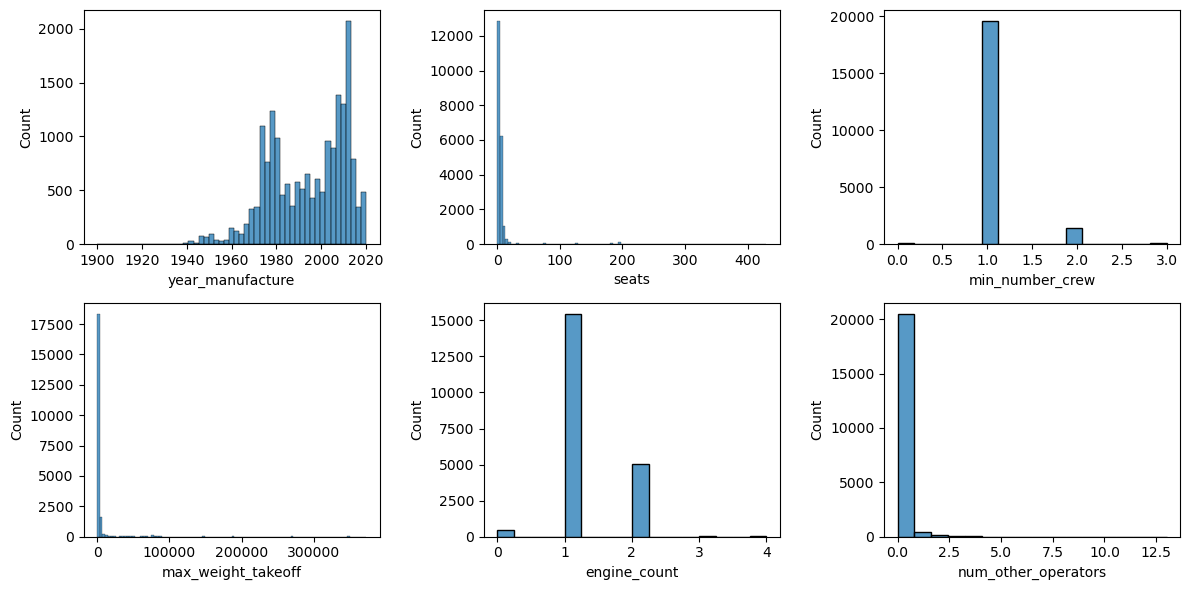

In [34]:
df_num = df.loc[:, ['year_manufacture', 'seats', 'min_number_crew',
                     'max_weight_takeoff', 'engine_count', 'num_other_operators']]

fig,ax = plt.subplots(2, 3, figsize = (12, 6))

for i, c in enumerate(df_num.columns):
    
    if c == 'max_weight_takeoff' or c == 'seats':
        
        sns.histplot(data = df, x = c, bins = 100, ax = ax[i//3, i%3])
        
    else:
        sns.histplot(data = df, x = c, ax = ax[i//3, i%3])

fig.tight_layout()

We can have the following insights based on the histograms made.

* There were two moments of great aircraft manufacture: the end of the 60s and the beginning of the 2010s.
* Seats and MTOW have a right-skewed distribution.
* The vast majority of planes require only one crew member.
* Most planes have one engine, followed by planes that have two. Airplanes with more than two are very rare, as are gliders.
* As seen earlier, it is rare for planes to have more than one operator.

In [35]:
sns.heatmap(df_num.corr(numeric_only = True), annot = True, fmt = '.2f', cmap = 'PuBu');

TypeError: corr() got an unexpected keyword argument 'numeric_only'

* Seats have a strong linear correlation with MTOW, which is to be expected. Only larger and consequently heavier planes can carry more passengers.
* Minimum Crew Number and Number of Engines are moderately correlated with MTOW and Seats. Larger planes may need more crew and engines.

## 2.5. Distribution Analysis

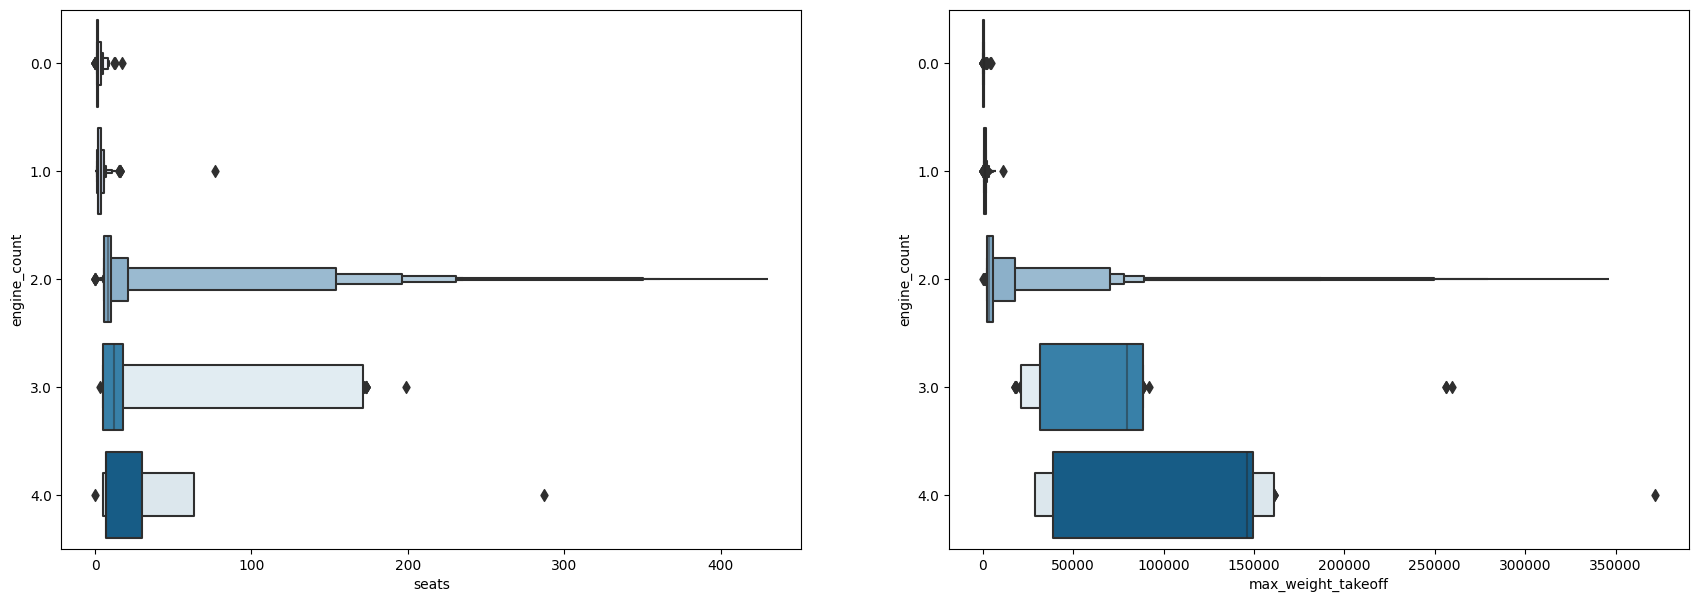

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (21, 7))
sns.boxenplot(data = df, y = 'engine_count', x = 'seats', scale = 'exponential', palette = 'PuBu', orient = 'h', ax = ax[0]);
sns.boxenplot(data = df, y = 'engine_count', x = 'max_weight_takeoff', scale = 'exponential', palette = 'PuBu', orient = 'h', ax = ax[1]);

Twin engine planes have a wider range of MTOW and seating, despite not being the most common type of plane. As more engines are added, the plane tends to increase its MTOW, as observed.

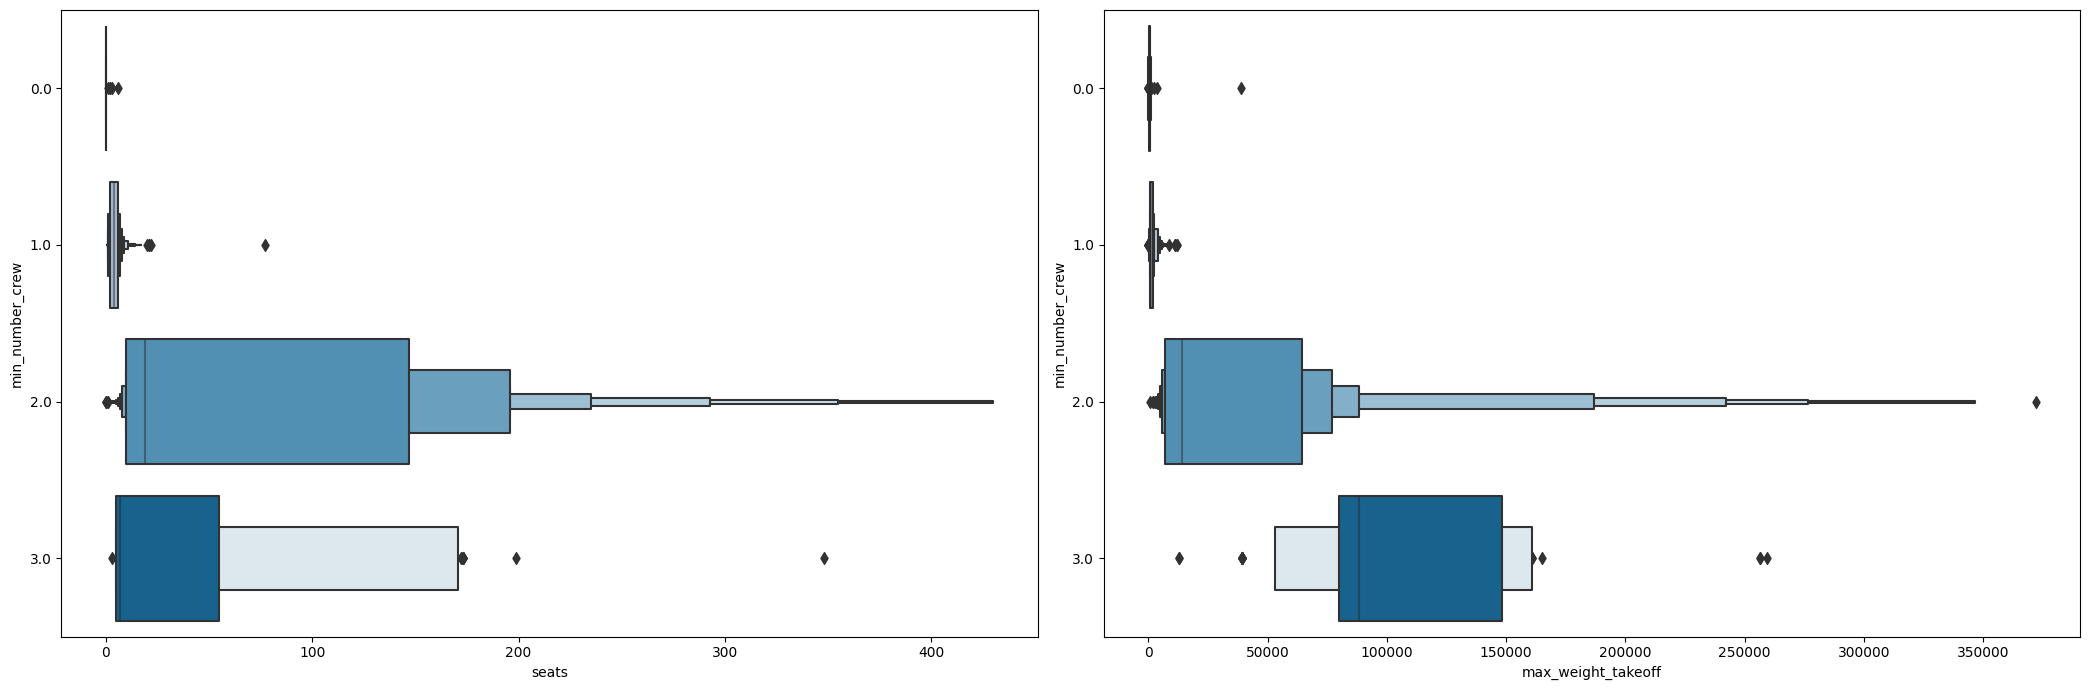

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (21, 7))
sns.boxenplot(data = df, y = 'min_number_crew', x = 'seats', scale = 'exponential', palette = 'PuBu', orient = 'h', ax = ax[0]);
sns.boxenplot(data = df, y = 'min_number_crew', x = 'max_weight_takeoff', scale = 'exponential', palette = 'PuBu', orient = 'h', ax = ax[1]);
fig.tight_layout()

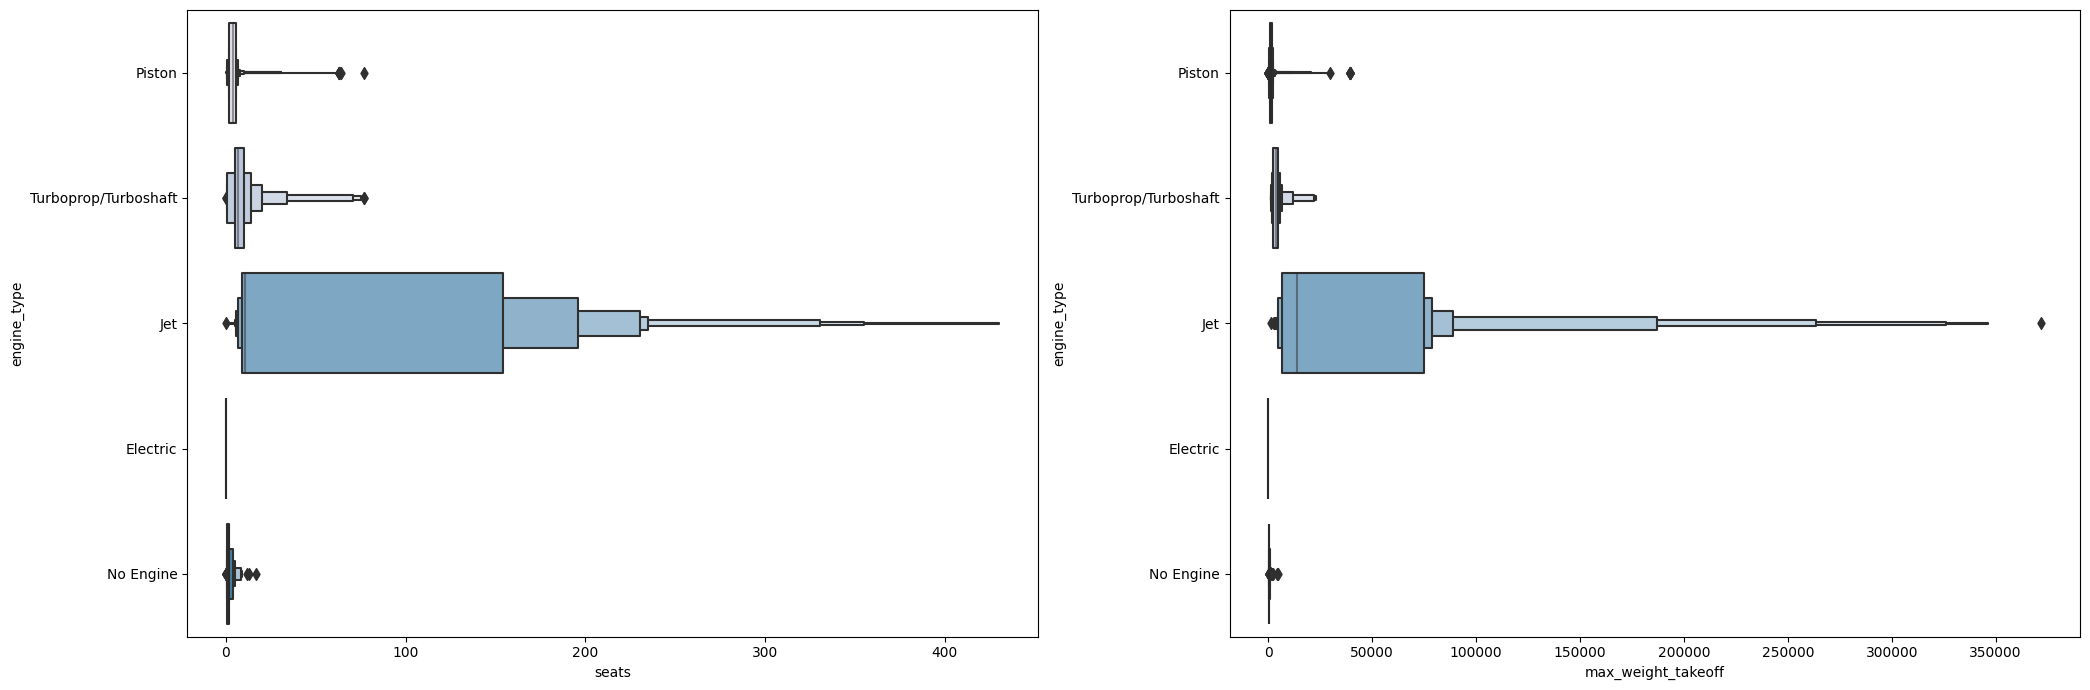

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (21, 7))
sns.boxenplot(data = df, y = 'engine_type', x = 'seats', scale = 'exponential', palette = 'PuBu', orient = 'h', ax = ax[0]);
sns.boxenplot(data = df, y = 'engine_type', x = 'max_weight_takeoff', scale = 'exponential', palette = 'PuBu', orient = 'h', ax = ax[1]);
fig.tight_layout()

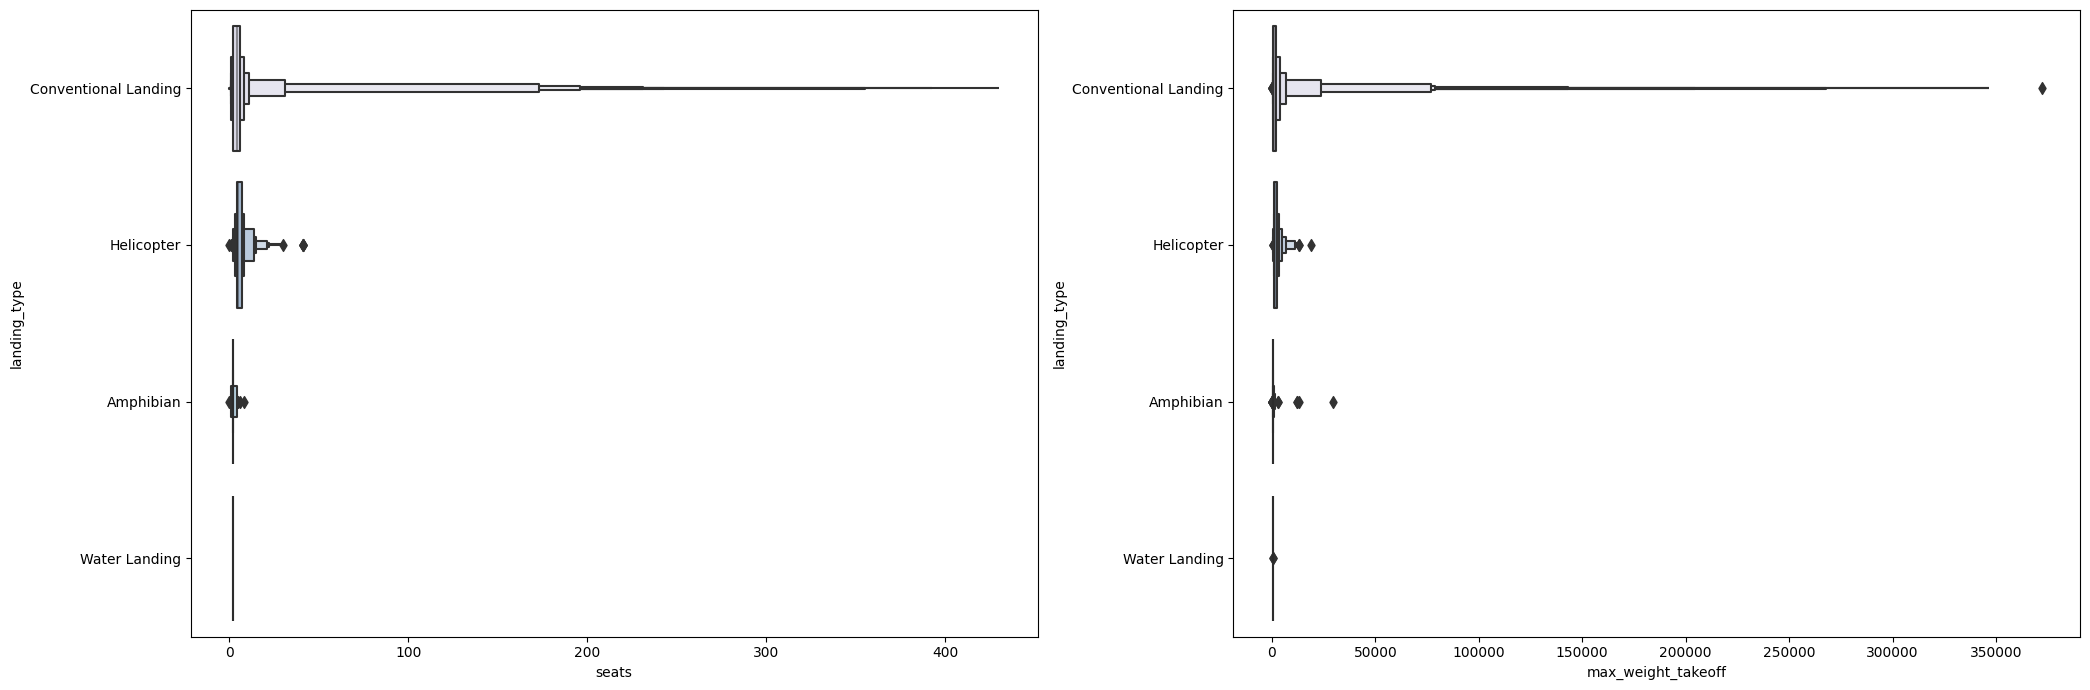

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (21, 7))
sns.boxenplot(data = df, y = 'landing_type', x = 'seats', scale = 'exponential', palette = 'PuBu', orient = 'h', ax = ax[0]);
sns.boxenplot(data = df, y = 'landing_type', x = 'max_weight_takeoff', scale = 'exponential', palette = 'PuBu', orient = 'h', ax = ax[1]);
fig.tight_layout()

## 2.6. Other Analysis

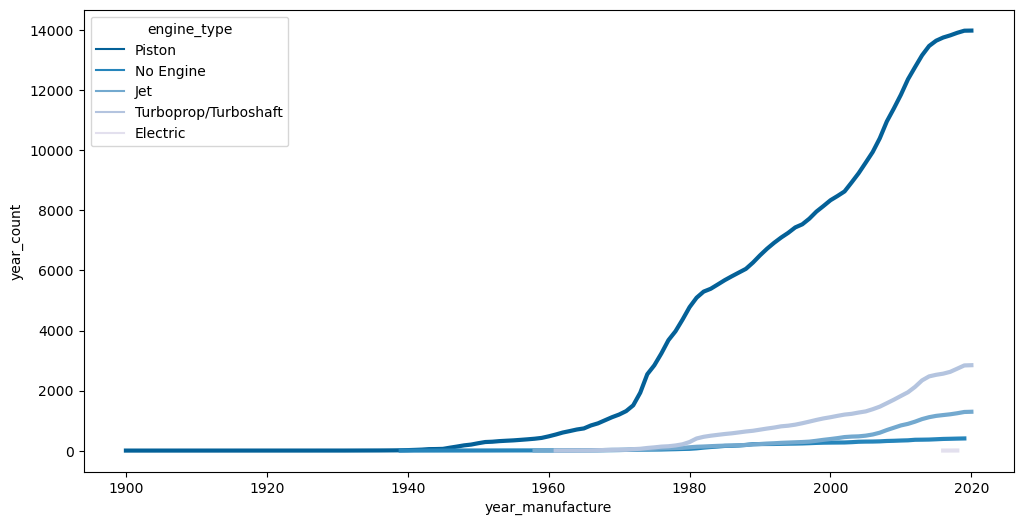

In [36]:
year_count = df.groupby(['year_manufacture', 'engine_type']).count()['owner']
year_count = year_count.groupby(level=1).cumsum()
year_count = year_count.reset_index()
year_count = year_count.rename(columns = {'owner': 'year_count'})

ab = sns.color_palette(palette='PuBu', n_colors=5).as_hex()

plt.figure(figsize = (12, 6))
sns.lineplot(data = year_count, x = 'year_manufacture', y = 'year_count', hue = 'engine_type', palette = ab[::-1], lw = 3);

Piston planes have had a strong presence on the Brazilian scene over the decades, with higher growth inclinations than other types of engines, such as Turboprop and Jet.

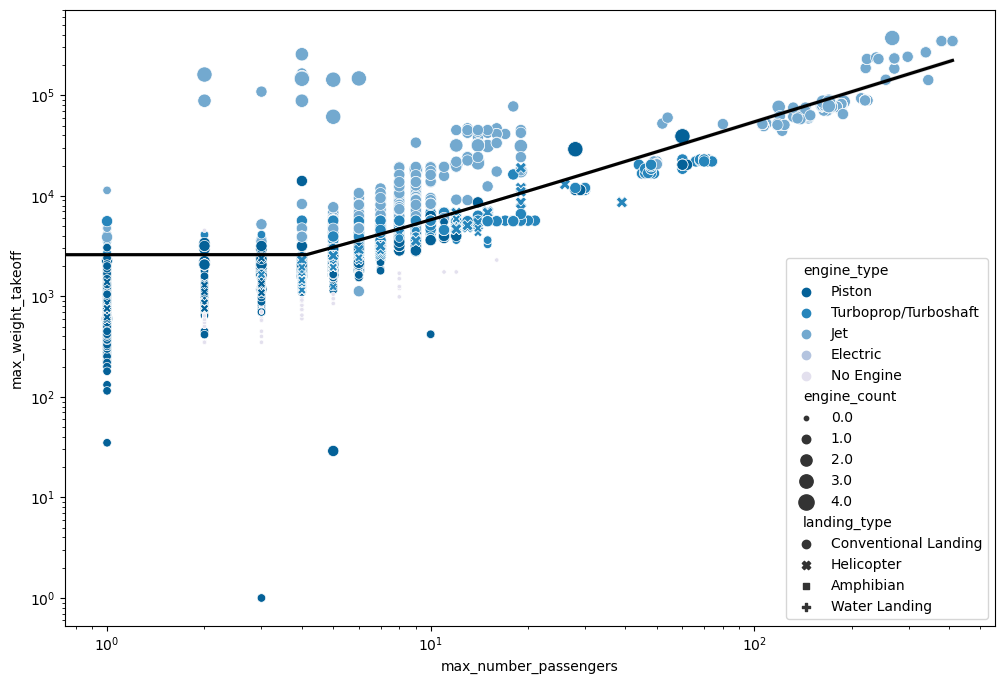

In [37]:
ab = sns.color_palette(palette='PuBu', n_colors=5).as_hex()

plt.figure(figsize = (12, 8))
sns.scatterplot(data = df, x = 'max_number_passengers', y = 'max_weight_takeoff',
                hue = 'engine_type', size = 'engine_count', style =  'landing_type',
                palette = ab[::-1], sizes = (10, 120));
sns.regplot(data=df, x = 'max_number_passengers', y = 'max_weight_takeoff', scatter = False, color = 'k')
plt.yscale('log')
plt.xscale('log')

* Applying the logarithmic transformation on the MTOW and the maximum number of passengers, a linear relationship between the variables is seen.
* Aircraft with three engines or more cluster at higher MTOW values, despite the relatively low maximum passenger numbers.
* Helicopters follow the same trend as aircraft with traditional accommodation.
* Gliders are underweight for their respective maximum passenger numbers.

# 3. Machine Learning

In this project, we developed a machine learning model capable of predicting the MTOW of an aircraft based on variables such as the maximum number of passengers, number of engines, engine type and landing type. The main purpose of this model is to support the initial phases of an aircraft design, when the objectives of the aircraft are being defined.

In [38]:
df['engine_type'] = df['engine_type'].astype('category')
df['landing_type'] = df['landing_type'].astype('category')

X_col = ['max_number_passengers', 'engine_count', 'engine_type', 'landing_type']
y_col = 'max_weight_takeoff'

In [39]:
mask1 = (df['engine_type'] == 'No Engine') | (df['engine_type'] == 'Eletric')
mask2 = (df['landing_type'] == 'Amphibian') | (df['landing_type'] == 'Water Landing')

Given the non-significant number of gliders, electric powered planes, amphibious and water landing exclusives, we will remove these values.

In [40]:
df_no = df.loc[(mask1 | mask2), :]
df = df.drop(df_no.index)
df = df.drop(df.loc[df[y_col].isna(), y_col].index)

In [41]:
kf = KFold(10, shuffle = True, random_state = 101)

X = df.loc[:, X_col]
y = df.loc[:, y_col]

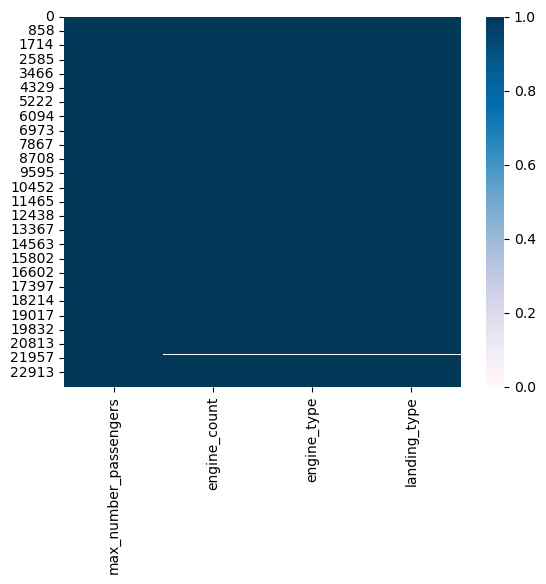

In [42]:
sns.heatmap(X.notna(), cmap = 'PuBu');

For the present work, two approaches will be considered using XGBoost: The first with a pre-processing, using the target encoder and logarithmic transformations in the variables, as well as an imputation process for missing data. In the second, no pre-processing is applied, only allowing XGBoost to work on categorical features. The chosen metric is MAE.

In [43]:
log_features = [0]
categorical_features = [2, 3]

def log1(x): return np.log(x + 1)

def exp1(x): return  np.e ** x - 1

log_transformer = Pipeline(steps = [
    ('log', FunctionTransformer(log1))
])

categorical_transformer = Pipeline(steps=[
    ('encoder', TargetEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', log_transformer, log_features),
    ('cat', categorical_transformer, categorical_features),
])

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('estimator', xgb.XGBRegressor()),
])

preprocessed_xgb = TransformedTargetRegressor(pipe, 
                           func = log1, 
                           inverse_func = exp1)


In [44]:
cross_val_score(preprocessed_xgb, X, y, scoring = 'neg_mean_absolute_error', cv = kf).mean()

-611.1243488952167

In [45]:
vanilla_xgb = xgb.XGBRegressor(enable_categorical = True, tree_method = 'hist')

cross_val_score(vanilla_xgb, X, y, scoring = 'neg_mean_absolute_error', cv = kf).mean()

-498.23461942090506

Given the results, we observed that the second approximation has a smaller validation error, being the most adequate for the application.

In [46]:
y_pred_val = cross_val_predict(vanilla_xgb, X, y, cv = kf)
y_pred_train =  vanilla_xgb.fit(X, y).predict(X)

cv_score = cross_val_score(vanilla_xgb, X, y, scoring = 'neg_mean_absolute_error', cv = kf).mean() * (-1)
train_score = mean_absolute_error(y_pred_train, y)

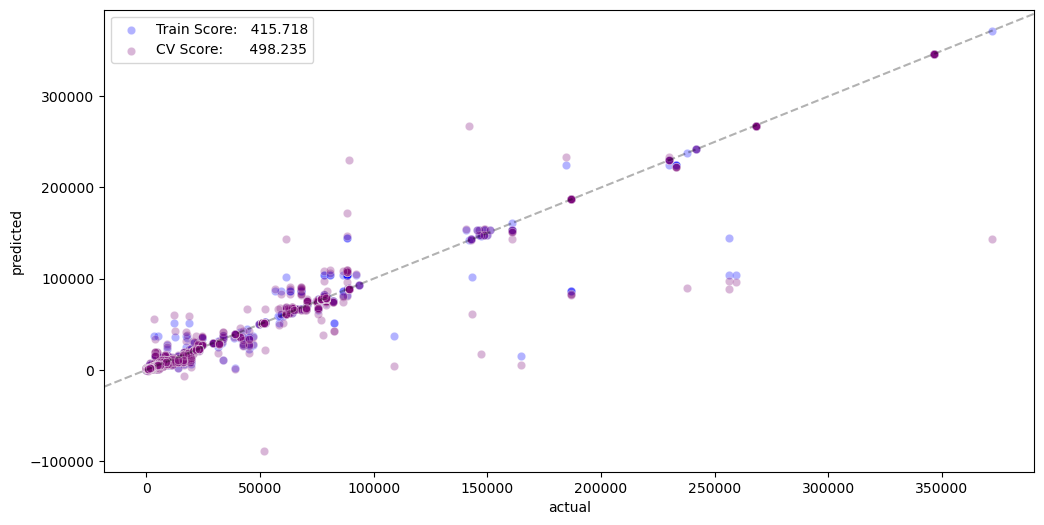

In [48]:
lb1 = 'CV Score: '
lb2 = 'Train Score: '

fig, ax = plt.subplots(1, 1, figsize = (12, 6))
sns.scatterplot(x = y, y = y_pred_train, ax = ax, alpha = 0.3, label = f'{lb2:15s}{train_score:.3f}', color = '#0000ff')
sns.scatterplot(x = y, y = y_pred_val, ax = ax, alpha = 0.3, label = f'{lb1:15s}{cv_score:.3f}', color = '#810f7c')
ax.axline([0, 0], [1, 1], ls = '--', c = 'k', alpha =0.3);
ax.set_xlabel('actual')
ax.set_ylabel('predicted');